<h1 style="font-size:30px;">KerasCV YOLOv8 Weighted Boxes Fusion</h1>

## Install Dependencies

In [ ]:
!pip install -q pycocotools ensemble-boxes
!pip install keras-cv tensorflow
!pip install tensorflow-text
!pip install tokenizers
!pip install tensorflow-gpu


  Using cached tensorflow-2.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (589.8 MB)
  Using cached ml_dtypes-0.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
  Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
  Using cached keras-3.2.1-py3-none-any.whl (1.1 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency 

In [ ]:
!pip install ensemble-boxes

In [ ]:
!pip install tensorflow==2.15.0

  Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
  Using cached ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Using cached tensorboard-2.15.2-py3-none-any.whl (5.5 MB)
  Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
ERROR: pip's dependency re

## Imports

In [1]:
import os
import glob
import requests
from zipfile import ZipFile

import itertools
import csv
import cv2

import numpy as np
import tensorflow as tf
import keras_cv
from keras_cv import bounding_box

from ensemble_boxes import weighted_boxes_fusion, nms

import matplotlib.pyplot as plt


Using TensorFlow backend


c:\Users\Rohan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## System configuration

In [2]:
def system_config():

    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')

    os.environ["CUDA_VISIBLE_DEVICES"] = '0'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    # Grow the memory usage as the process needs it.
    # tf.config.experimental.set_memory_growth(gpu_devices[0], True)

    # Enable using cudNN.
    os.environ['TF_USE_CUDNN'] = "true"

system_config()

In [3]:
DATASET_DIR = "C:\\Users\\Rohan\\Desktop\\mini proj\\global-wheat-detection\\test"




CHECKPOINT_DIR = "yolov8-models-kerascv"




## Map ImageID with Resoultions

In [4]:
def get_data_resolution(image_dir_path, img_files):

    image_res = {}

    for img_file in img_files:
        img_filepath = os.path.join(image_dir_path, img_file)
        if img_file != ".ipynb_checkpoints":
          print(img_filepath)
          image_id = img_file.strip().split(".")[0]
          print(image_id)
          image = cv2.imread(img_filepath)
          print(image.shape)
          image_res[image_id] = image.shape[:2]

    return image_res

## Preprocess Input Image Data

In [5]:
def read_preprocess_image(image_path, resize):

    image_raw = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_raw, channels=3)

    og_image_shape = tf.shape(image)[:2]

    image = tf.image.resize(images=image, size=resize, method = "bicubic")
    image = tf.cast(tf.clip_by_value(image, 0., 255.), tf.float32)

    return image, og_image_shape.numpy()

## Resize Predicted Boxes to Original Dimensions

In [6]:
def denorm_boxes(bbox_coords, im_shape, resize):

    ratio_wh  = im_shape / resize

    im_shape_lst = im_shape.tolist()
    ratio_multipler = np.concatenate([ratio_wh, ratio_wh], axis=-1)

    bbox_resize = bbox_coords * ratio_multipler
    bbox_resize = np.clip(bbox_resize,
                          a_min=[0., 0., 0., 0.],
                          a_max=im_shape_lst+im_shape_lst
                          )

    return bbox_resize

## Obtain Model Predictions

In [7]:
def get_predictions(model, image_dir_path, image_filenames, resize=(832, 832)):

    all_pred_scores = {}
    all_pred_boxes = {}
    all_pred_classes = {}

    for image_file in image_filenames:
        if image_file != ".ipynb_checkpoints":
          img_filepath = os.path.join(image_dir_path, image_file)
          image_id = image_file.strip().split(".")[0]

          image_tensor, im_shape = read_preprocess_image(img_filepath, resize=resize)
          image_batch = tf.expand_dims(image_tensor, axis=0)

          pred_results = model.predict(image_batch, verbose=0)
          pred_batch = bounding_box.to_ragged(pred_results)

          pred_boxes = tf.squeeze(pred_batch["boxes"], axis=0).numpy()
          pred_confs = tf.squeeze(pred_batch["confidence"], axis=0).numpy()
          pred_cls = tf.squeeze(pred_batch["classes"], axis=0).numpy().astype("int")

          pred_boxes = denorm_boxes(pred_boxes, im_shape, resize)

          if not len(pred_boxes):
              all_pred_boxes[image_id] = []
              all_pred_classes[image_id] = []
              all_pred_scores[image_id] = []

          else:
              all_pred_scores[image_id] = np.expand_dims(pred_confs, axis=1)
              all_pred_boxes[image_id] = pred_boxes
              all_pred_classes[image_id] = np.expand_dims(pred_cls, axis=1)

    return all_pred_scores, all_pred_boxes, all_pred_classes

## Load YOLOv8 Model Weights

In [8]:
def load_model_weights(backbone_name, pred_decoder, weights_path, fpn_depth=2):

    backbone = keras_cv.models.YOLOV8Backbone.from_preset(
                    backbone_name, load_weights=False
                )

    detector = keras_cv.models.YOLOV8Detector(
                    num_classes=1,
                    bounding_box_format="xyxy",
                    backbone=backbone,
                    fpn_depth=fpn_depth,
                    prediction_decoder=pred_decoder
                )

    detector.load_weights(weights_path)

    return detector

## Initialize KerasCV YOLOv8 Models

In [9]:
prediction_decoder = keras_cv.layers.NonMaxSuppression(
                    bounding_box_format="xyxy",
                    from_logits=False,
                    iou_threshold=0.5,
                    confidence_threshold=0.22
                )

model_dict = dict()

ckpt_files = os.listdir(CHECKPOINT_DIR)

for file in ckpt_files:
    model_type = file.split("_")[-1].split(".")[0]
    backbone = f"yolo_v8_{model_type}_backbone_coco"
    if model_type == "l":
        fpn_depth = 3
    else:
        fpn_depth = 2
    model_dict["yolov8_"+model_type] = load_model_weights(
                                        backbone_name=backbone,
                                        pred_decoder=prediction_decoder,
                                        weights_path=os.path.join(
                                                    CHECKPOINT_DIR, file),
                                        fpn_depth=fpn_depth
                                      )




In [16]:
print(model_dict)

{'yolov8_l': <keras_cv.src.models.object_detection.yolo_v8.yolo_v8_detector.YOLOV8Detector object at 0x0000012B32321ED0>, 'yolov8_m': <keras_cv.src.models.object_detection.yolo_v8.yolo_v8_detector.YOLOV8Detector object at 0x0000012B43166050>, 'yolov8_s': <keras_cv.src.models.object_detection.yolo_v8.yolo_v8_detector.YOLOV8Detector object at 0x0000012B467A7410>}


In [10]:
TEST_IMG_DIR = os.path.join(DATASET_DIR, )
test_image_files = os.listdir(TEST_IMG_DIR)

## Obtain Predictions across Models

In [11]:
data_res_dict = get_data_resolution(TEST_IMG_DIR, test_image_files)

CLASSES_DICT = {0:"wheat_head"}

pred_confs   = []
pred_boxes   = []
pred_classes = []

for model in model_dict.values():
    confs_scores, box_preds, cls_preds = get_predictions(model, TEST_IMG_DIR, test_image_files)
    pred_confs.append(confs_scores)
    pred_boxes.append(box_preds)
    pred_classes.append(cls_preds)

C:\Users\Rohan\Desktop\mini proj\global-wheat-detection\test\00b5fefed.jpg
00b5fefed
(1024, 1024, 3)
C:\Users\Rohan\Desktop\mini proj\global-wheat-detection\test\00b70a919.jpg
00b70a919
(1024, 1024, 3)
C:\Users\Rohan\Desktop\mini proj\global-wheat-detection\test\0b2967a7a.jpg
0b2967a7a
(1024, 1024, 3)
C:\Users\Rohan\Desktop\mini proj\global-wheat-detection\test\0b47876ec.jpg
0b47876ec
(1024, 1024, 3)
C:\Users\Rohan\Desktop\mini proj\global-wheat-detection\test\0b7712f7a.jpg
0b7712f7a
(1024, 1024, 3)
C:\Users\Rohan\Desktop\mini proj\global-wheat-detection\test\0b9624bd4.jpg
0b9624bd4
(1024, 1024, 3)
C:\Users\Rohan\Desktop\mini proj\global-wheat-detection\test\0ba2166af.jpg
0ba2166af
(1024, 1024, 3)
C:\Users\Rohan\Desktop\mini proj\global-wheat-detection\test\0bb1adbd8.jpg
0bb1adbd8
(1024, 1024, 3)
C:\Users\Rohan\Desktop\mini proj\global-wheat-detection\test\0bb98c55d.jpg
0bb98c55d
(1024, 1024, 3)


## Perform Weighted Boxes Fusion (WBF)

In [12]:
def perform_weighted_boxes_fusion(
        pred_confs_models,
        pred_boxes_models,
        pred_classes_models,
        resolution_dict,
        IOU_THRESH=0.50,
        CONF_THRESH=0.45,
        FINAL_CONF_THRESH=.40):

    wbf_boxes_dict = {}
    wbf_scores_dict = {}

    for image_id, res in resolution_dict.items():

        res_array = np.array([res[1], res[0], res[1], res[0]]) # [W, H, W, H]

        all_model_boxes   = []
        all_model_scores  = []
        all_model_classes = []

        for boxes, scores, classes in zip(pred_boxes_models, pred_confs_models, pred_classes_models):
            pred_boxes_norm = (boxes[image_id] / res_array).clip(min=0., max=1.)
            scores_model = scores[image_id]
            classes_model = classes[image_id]

            all_model_boxes.append(pred_boxes_norm)
            all_model_scores.append(scores_model)
            all_model_classes.append(classes_model)


        # Perform weighted boxes fusion.
        boxes, scores, labels = weighted_boxes_fusion(
                                    all_model_boxes,
                                    all_model_scores,
                                    all_model_classes,
                                    weights=None, iou_thr=IOU_THRESH, skip_box_thr=CONF_THRESH)


        if len(boxes):
            # Further filter boxes having scores > FINAL_CONF_THRESH
            final_scores_ids = np.where(scores > FINAL_CONF_THRESH)[0]

            final_boxes = boxes[final_scores_ids]
            final_scores = scores[final_scores_ids]

            final_boxes = (final_boxes*res_array).clip(min=[0.,0.,0.,0.],
                                                       max=[res[1]-1, res[0]-1, res[1]-1, res[0]-1])

            final_boxes = final_boxes.astype("int")

            final_boxes[:,2:] = final_boxes[:,2:] - final_boxes[:, :2]

            wbf_boxes_dict[image_id] = final_boxes.tolist()
            wbf_scores_dict[image_id] = np.expand_dims(final_scores, axis=-1).tolist()

        else:
            wbf_boxes_dict[image_id] = []
            wbf_scores_dict[image_id] = []


    return wbf_boxes_dict, wbf_scores_dict

In [13]:
boxes_dict, scores_dict = perform_weighted_boxes_fusion(
                                pred_confs,
                                pred_boxes,
                                pred_classes,
                                data_res_dict,
                                IOU_THRESH=0.50,
                                CONF_THRESH=0.22,
                                FINAL_CONF_THRESH=0.2)

## Visualize Predictions from Weighted Boxes Fusion (WBF)

In [14]:
def draw_bbox(
    image,
    boxes,
    classes,
    scores=None,
    color=(255, 0, 0),
    thickness=-1):

    overlay = image.copy()

    font_size = 0.25 + 0.07 * min(overlay.shape[:2]) / 100
    font_size = max(font_size, 0.5)
    font_size = min(font_size, 0.8)
    text_offset = 7

    for idx, (box, cls) in enumerate(zip(boxes, classes)):
        xmin, ymin, box_w, box_h = box[0], box[1], box[2], box[3]
        xmax = xmin + box_w
        ymax = ymin+box_h
        if scores is not None and scores[idx][0] > 0.5:
          overlay = cv2.rectangle(overlay, (xmin, ymin), (xmax, ymax), color, thickness)

          display_text = f"{CLASSES_DICT[cls]}"

          if scores is not None:
              display_text+= f": {scores[idx][0]:.2f}"

          (text_width, text_height), _ = cv2.getTextSize(display_text, cv2.FONT_HERSHEY_SIMPLEX, font_size, 2)

          cv2.rectangle(overlay,
                        (xmin, ymin),
                        (xmin + text_width + text_offset, ymin - text_height - int(15 * font_size)),
                        color, thickness=-1)


          overlay = cv2.putText(
                      overlay,
                      display_text,
                      (xmin + text_offset, ymin - int(10 * font_size)),
                      cv2.FONT_HERSHEY_SIMPLEX,
                      font_size,
                      (255, 255, 255),
                      2, lineType=cv2.LINE_AA,
                  )

    return cv2.addWeighted(overlay, 0.75, image, 0.25, 0)

In [15]:
def plot_vis(filename, img, pred_boxes, conf_scores):

    img_to_plot = img.copy()

    classes = np.zeros(len(pred_boxes), dtype="int")

    img_to_plot = draw_bbox(img_to_plot, pred_boxes, classes, conf_scores, thickness=4)

    cv2.imwrite(f"yolov8_wbf_inference/{filename}", img_to_plot[...,::-1])
    plt.imshow(img_to_plot)
    plt.axis("off")
    plt.show()

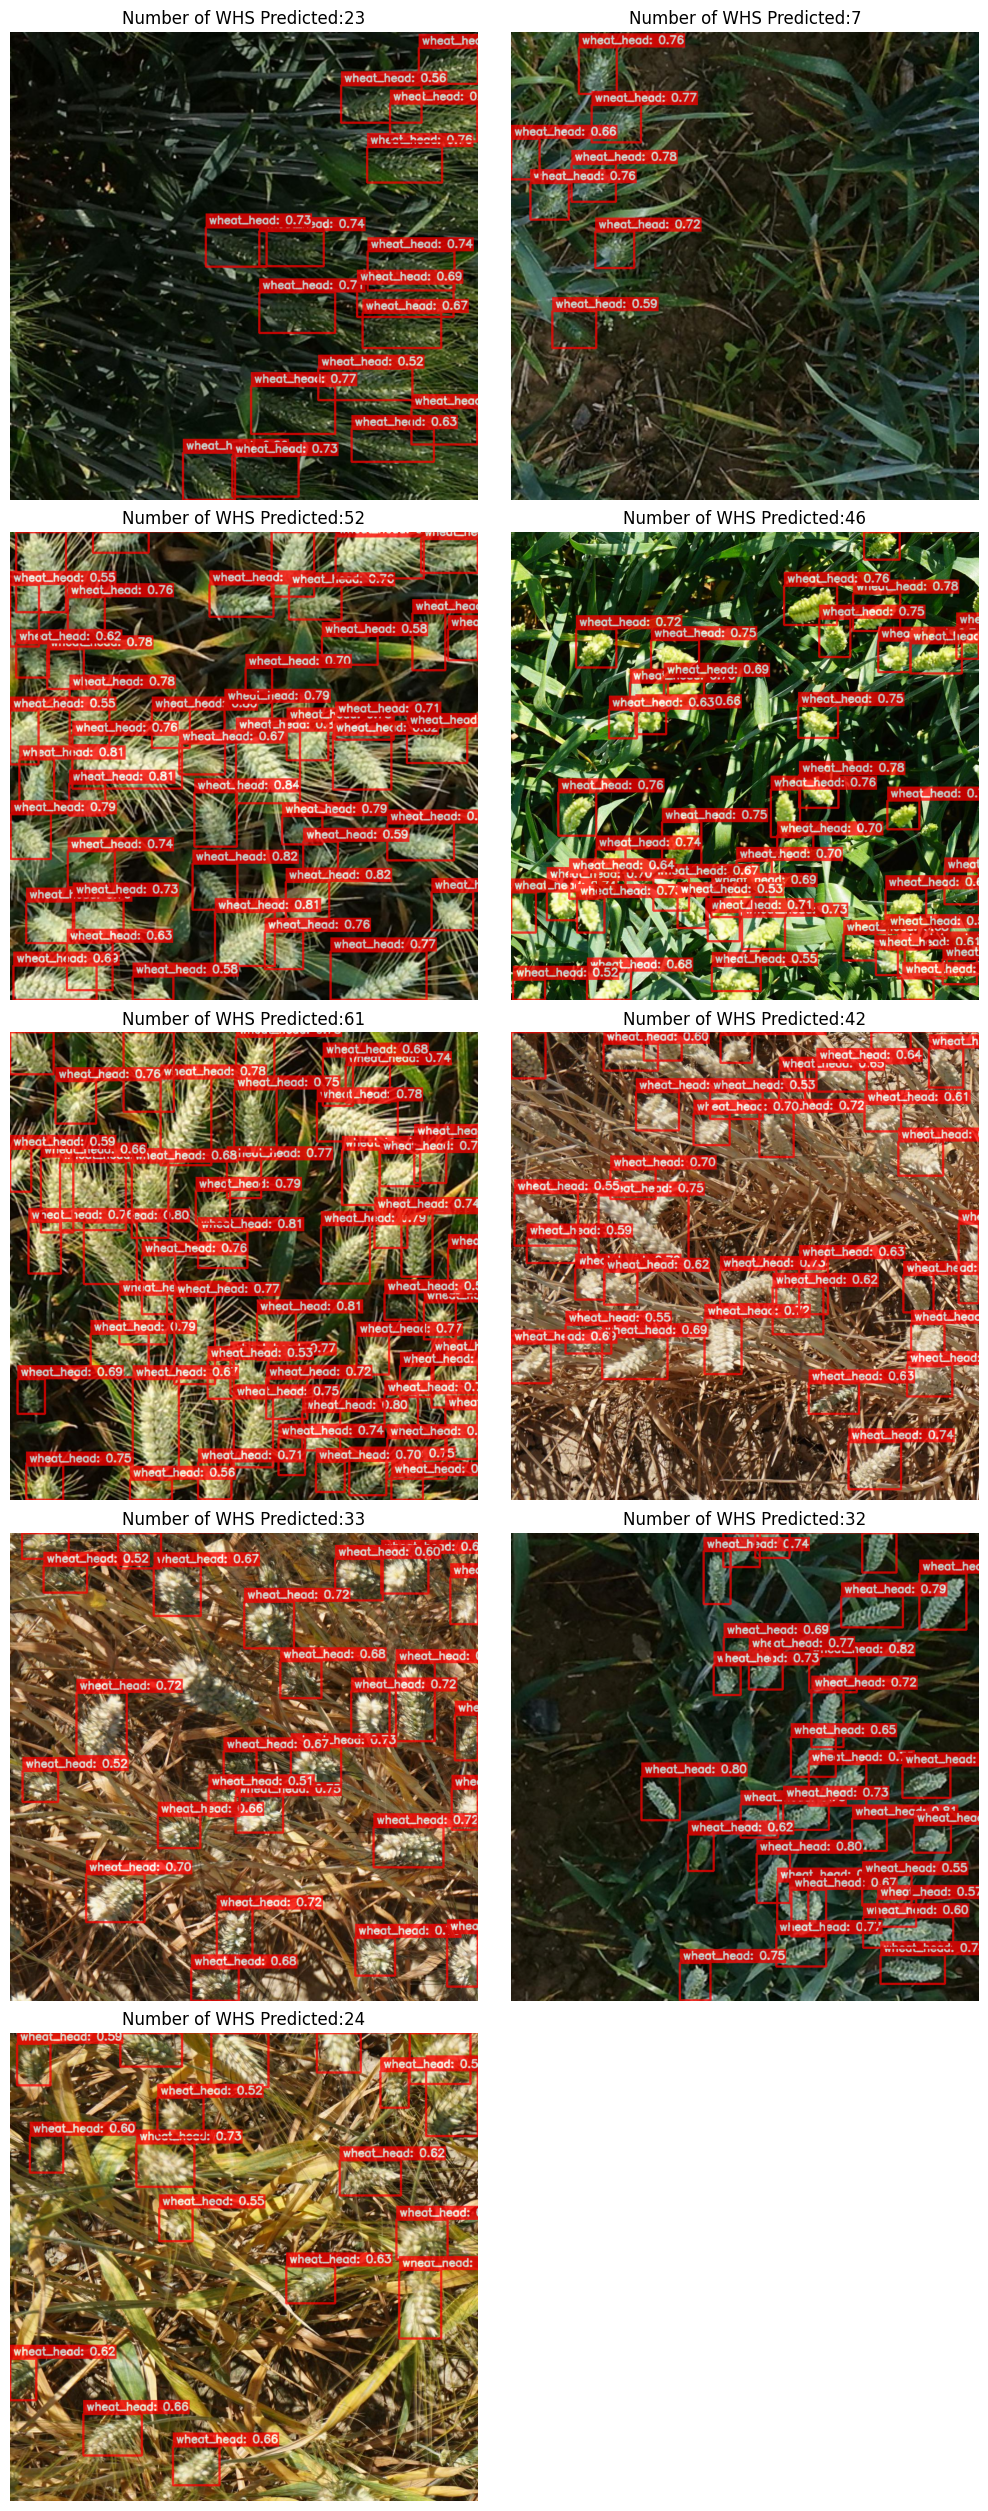

In [16]:
fig = plt.figure(figsize=(10, 25), layout="constrained")

for i,(img_file, box_data, confs) in enumerate(zip(test_image_files, boxes_dict.values(), scores_dict.values())):
    filename = os.path.join(TEST_IMG_DIR, img_file)
    image = cv2.imread(filename)[...,::-1]
    classes = np.zeros(len(box_data), dtype="int")
    image =  draw_bbox(image,
                       box_data,
                       classes,
                       confs,
                       thickness=4)


    ax = plt.subplot(5, 2, i+1)
    plt.imshow(image)
    plt.axis("off")
    ax.set_title(f"Number of WHS Predicted:{len(box_data)}")

plt.show()